# 04- Conditional Value at Risk

_This setup code is required to run in an IPython notebook_

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

## Data
These examples make use of S&P 500 data from Yahoo! that is available from `arch.data.sp500`.

In [2]:
import datetime as dt
import sys

import arch.data.sp500
import numpy as np
import pandas as pd
from arch import arch_model

data = arch.data.sp500.load()
market = data["Adj Close"]
returns = 100 * market.pct_change().dropna()

# Value-at-Risk Forecasting

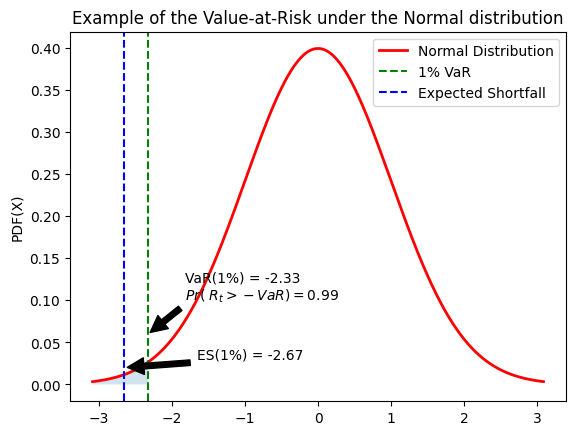

In [9]:
# Set the mean and standard deviation of the normal distribution
from scipy.stats import norm
mu = 0; sigma = 1
alpha = 0.01

# Generate 1000 random values from the normal distribution
x = np.linspace(norm.ppf(0.001, mu, sigma), norm.ppf(0.999, mu, sigma), 1000)
# Calculate the 5% value at risk (VaR)
VaR = norm.ppf(alpha, mu, sigma)
# Value-at Risk
ES = norm.pdf(norm.ppf(alpha))/alpha

# Plot the normal distribution
plt.plot(x, norm.pdf(x, mu, sigma), 'r-', lw=2, label='Normal Distribution')


x_fill = np.linspace(norm.ppf(0.001, mu, sigma), VaR, 100)
plt.fill_between(x_fill, norm.pdf(x_fill, mu, sigma), alpha=0.2)

# Add a vertical line and annotation for the VaR value
plt.axvline(x=VaR, color='g', linestyle='--', label=f'{int(alpha*100)}% VaR')
plt.annotate(f'VaR({int(alpha*100)}%) = {VaR:.2f}\n$Pr(~R_t>-VaR) = {1-alpha}$', xy=(VaR, 0.06), xytext=(VaR + 0.5, 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Add a vertical line and annotation for the ES value
plt.axvline(x=-ES, color='b', linestyle='--', label='Expected Shortfall')
plt.annotate(f'ES({int(alpha*100)}%) = {-ES:.2f}', xy=(-ES, 0.02), xytext=(-ES +1, 0.03),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.legend(loc='best')
plt.ylabel('PDF(X)')
plt.title('Example of the Value-at-Risk under the Normal distribution')
# Show the plot
plt.show()

Exercise 1:

Computer the 5% Value at Risk

Value-at-Risk (VaR) forecasts from GARCH models depend on the conditional mean, the conditional volatility and the quantile of the standardized residuals,

$$VaR_{t+1|t} = -\mu_{t+1|t} - \sigma_{t+1|t} q_{\alpha}$$

where $q_{\alpha}$ is the $\alpha$ quantile of the standardized residuals, e.g., 5%. 

The quantile can be either computed from the estimated model density or computed using the empirical distribution of the standardized residuals.  The example below shows both methods.

In [14]:
am = arch_model(returns, vol="Garch", p=1, o=0, q=1, dist="skewt")
res = am.fit(disp="off", last_obs="2017-12-31")

## Parametric VaR
First, we use the model to estimate the VaR.  The quantiles can be computed using the `ppf` method of the distribution attached to the model. The quantiles are printed below.

In [15]:
forecasts = res.forecast(start="2018-1-1", reindex=False)
cond_mean = forecasts.mean["2018":]
cond_var = forecasts.variance["2018":]
q = am.distribution.ppf([0.01, 0.05], res.params[-2:])
print(q)

[-2.64484859 -1.6496597 ]


Next, we plot the two VaRs along with the returns.  The returns that violate the VaR forecasts are highlighted. 

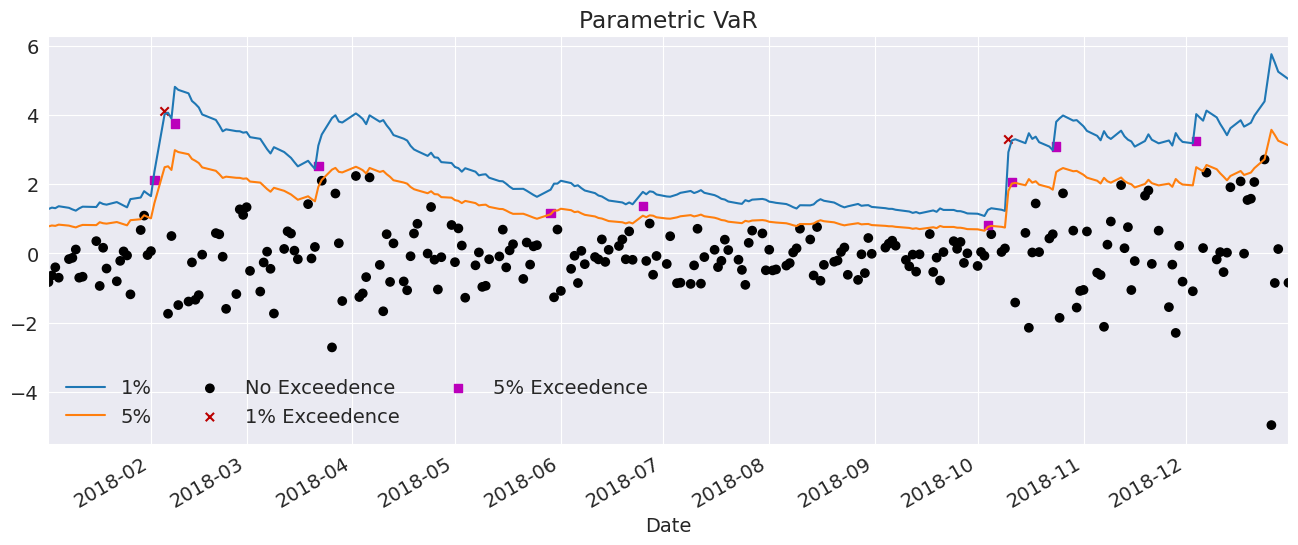

In [16]:
value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q[None, :]
value_at_risk = pd.DataFrame(value_at_risk, columns=["1%", "5%"], index=cond_var.index)
ax = value_at_risk.plot(legend=False)
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])
rets_2018 = returns["2018":].copy()
rets_2018.name = "S&P 500 Return"
c = []
for idx in value_at_risk.index:
    if rets_2018[idx] > -value_at_risk.loc[idx, "5%"]:
        c.append("#000000")
    elif rets_2018[idx] < -value_at_risk.loc[idx, "1%"]:
        c.append("#BB0000")
    else:
        c.append("#BB00BB")
c = np.array(c, dtype="object")
labels = {
    "#BB0000": "1% Exceedence",
    "#BB00BB": "5% Exceedence",
    "#000000": "No Exceedence",
}
markers = {"#BB0000": "x", "#BB00BB": "s", "#000000": "o"}
for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2018.index[sel],
        -rets_2018.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color],
    )
ax.set_title("Parametric VaR")
leg = ax.legend(frameon=False, ncol=3)

## Filtered Historical Simulation

Next, we use the empirical distribution of the standardized residuals to estimate the quantiles.  These values are very similar to those estimated using the assumed distribution.  The plot below is identical except for the slightly different quantiles.

In [17]:
std_rets = (returns[:"2017"] - res.params["mu"]) / res.conditional_volatility
std_rets = std_rets.dropna()
q = std_rets.quantile([0.01, 0.05])
print(q)

0.01   -2.668273
0.05   -1.723353
dtype: float64


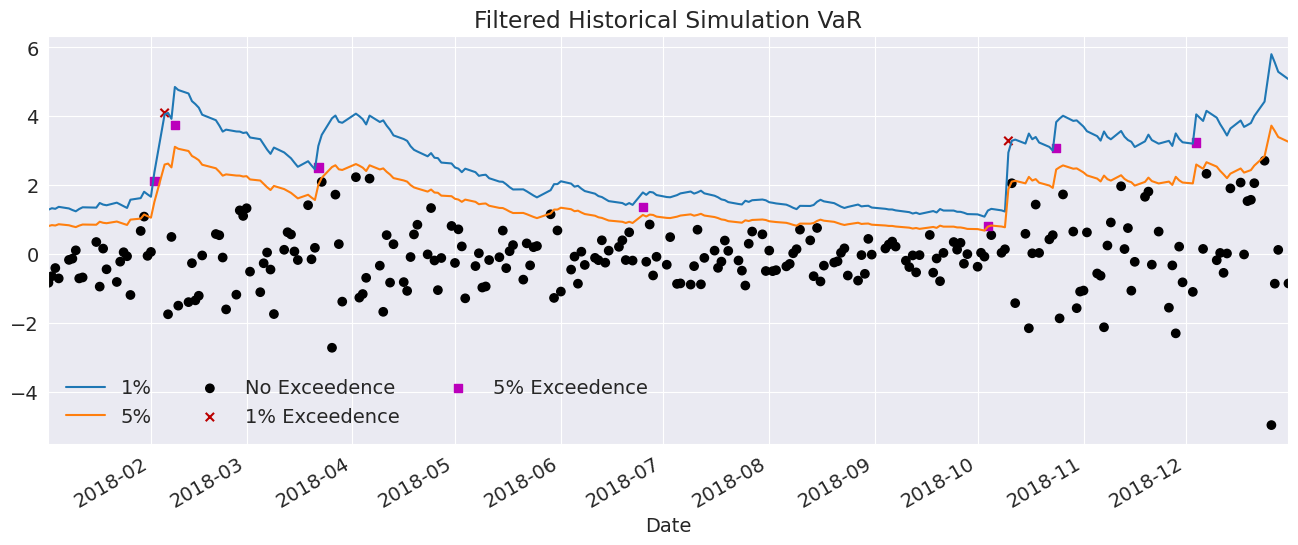

In [18]:
value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q.values[None, :]
value_at_risk = pd.DataFrame(value_at_risk, columns=["1%", "5%"], index=cond_var.index)
ax = value_at_risk.plot(legend=False)
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])
rets_2018 = returns["2018":].copy()
rets_2018.name = "S&P 500 Return"
c = []
for idx in value_at_risk.index:
    if rets_2018[idx] > -value_at_risk.loc[idx, "5%"]:
        c.append("#000000")
    elif rets_2018[idx] < -value_at_risk.loc[idx, "1%"]:
        c.append("#BB0000")
    else:
        c.append("#BB00BB")
c = np.array(c, dtype="object")
for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2018.index[sel],
        -rets_2018.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color],
    )
ax.set_title("Filtered Historical Simulation VaR")
leg = ax.legend(frameon=False, ncol=3)

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t, skewnorm, gennorm

# Set random seed for reproducibility
np.random.seed(1234)

# Generate data from different distributions
x_norm = np.linspace(norm.ppf(0.001), norm.ppf(0.999), 100)
y_norm = norm.pdf(x_norm, loc=0, scale=1)

x_t = np.linspace(t.ppf(0.01, df=3), t.ppf(0.99, df=3), 100)
y_t = t.pdf(x_t, df=3, loc=0, scale=1)

x_skewt = np.linspace(skewnorm.ppf(0.001, a=4), skewnorm.ppf(0.999, a=4), 100)
y_skewt = skewnorm.pdf(x_skewt, a=4, loc=0, scale=1)

x_ged = np.linspace(gennorm.ppf(0.001, beta=2, loc=0, scale=1), 
                    gennorm.ppf(0.999, beta=2, loc=0, scale=1), 100)
y_ged = gennorm.pdf(x_ged, beta=2, loc=0, scale=1)

# Plot the distributions
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(x_norm, y_norm, 'b-', lw=2, label='Normal')
ax.plot(x_t, y_t, 'g-', lw=2, label='Student t')
ax.plot(x_skewt, y_skewt, 'r-', lw=2, label='Skewed Student t')
ax.plot(x_ged, y_ged, 'm-', lw=2, label='GED')

ax.legend(loc='best')
ax.set_xlabel('X')
ax.set_ylabel('Density')
ax.set_title('Most used Distributions')
plt.show()
